---

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import urllib.parse
import seaborn as sns
from tqdm import tqdm
import src.data.data_loader as data_loader
import networkx as nx
from ipywidgets import widgets
from sklearn.manifold import TSNE

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [3]:
all_paths, paths_finished, paths_unfinished = data_loader.load_paths()
articles = data_loader.load_articles()
categories = data_loader.load_categories()
links = data_loader.load_links()
distance_matrix = data_loader.load_distance_matrix()

In [4]:
#generate all the data needed for the analysis, Skip if already generated
#import src.data.data_generation as data_generation  

#data_generation.generate_embeddings()
#data_generation.generate_all_path_similarities(output_file='data/path_similarities.csv')
#data_generation.generate_analysis_links(links, distance_matrix)
#data_generation.wayanalysis(links, distance_matrix)
#data_generation.missing_links_but_present(links, distance_matrix)
#data_generation.missing_links_but_present_all_complete_full_integral(links, distance_matrix)

---

### Basic analysis


In [5]:
print(f"Across the study, we have {len(paths_finished)} finished paths, while {len(paths_unfinished)} remain unfinished, for a total of {len(all_paths)} paths.")

Across the study, we have 51318 finished paths, while 24875 remain unfinished, for a total of 76193 paths.


---

# Frustration

Our initial approach to measuring player frustration focuses on analyzing instances of backtracking. When players need to retrace their steps within a game, it often signals an increase in difficulty, which can be directly linked to frustration. Let's dive into it :

In [6]:
# Calculate the average number of backtracks for finished vs unfinished paths
avg_backtracks_finished = all_paths[all_paths['status'] == 'finished']['backtracks'].apply(len).mean()
avg_backtracks_unfinished = all_paths[all_paths['status'] != 'finished']['backtracks'].apply(len).mean()

# Output the results
print("\nAverage number of backtracks per game:")
print(f"Finished paths: {avg_backtracks_finished:.2f}")
print(f"Unfinished paths: {avg_backtracks_unfinished:.2f}")


Average number of backtracks per game:
Finished paths: 0.40
Unfinished paths: 0.52


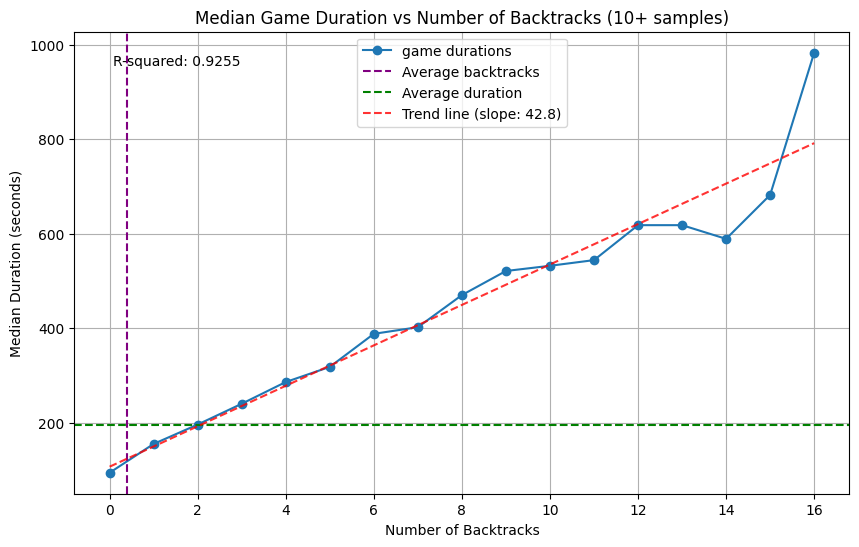

In [7]:
# Get finished games with and without backtracks

finished_with_bt = paths_finished[paths_finished['backtracks'].apply(len) > 0]
finished_no_bt = paths_finished[paths_finished['backtracks'].apply(len) == 0]

# Calculate average duration for each group
avg_duration_with_bt = finished_with_bt['durationInSec'].median()
avg_duration_no_bt = finished_no_bt['durationInSec'].median()

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_durations = paths_finished.groupby(paths_finished['backtracks'].apply(len))['durationInSec'].median()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_durations = backtrack_durations[filtered_counts.index]

plt.figure(figsize=(10,6))
plt.plot(filtered_durations.index, filtered_durations.values, marker='o', label='game durations')
plt.axvline(x=avg_backtracks_finished, color='purple', linestyle='--', label='Average backtracks')
plt.axhline(y=avg_duration_with_bt, color='g', linestyle='--', label='Average duration')
plt.xlabel('Number of Backtracks')
plt.ylabel('Median Duration (seconds)')
plt.title('Median Game Duration vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_durations.index, filtered_durations.values, 1)
p = np.poly1d(z)
plt.plot(filtered_durations.index, p(filtered_durations.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_durations.values, p(filtered_durations.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

In today’s fast-paced world, where content is rapidly consumed, players’ attention spans are increasingly shorter. If a game drags on too long, frustration can build as players wait longer for the rewarding sense of completion. As illustrated in the graph above, there is a noticeable correlation between the frequency of backtracking and overall game duration: each backtrack adds an average of 43 seconds to the game time.

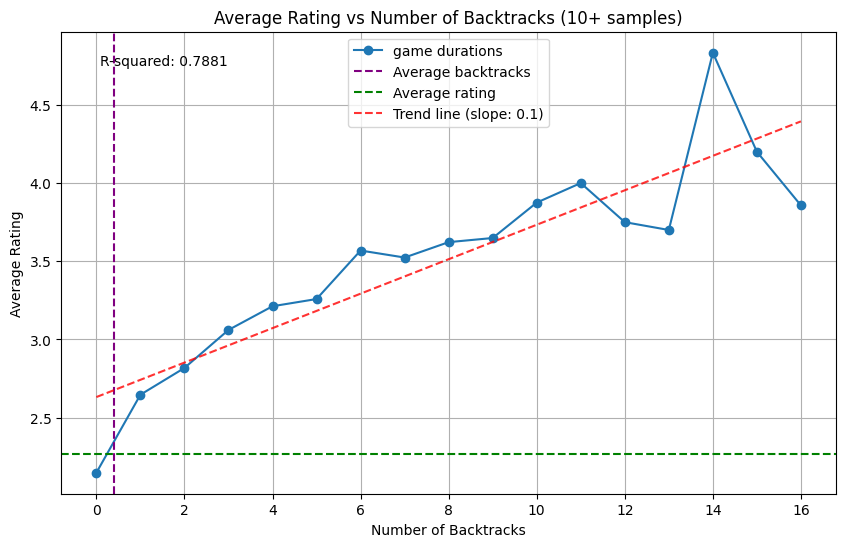

In [8]:
# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_ratings = paths_finished.groupby(paths_finished['backtracks'].apply(len))['rating'].mean()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_ratings = backtrack_ratings[filtered_counts.index]


plt.figure(figsize=(10,6))
plt.plot(filtered_ratings.index, filtered_ratings.values, marker='o', label='game durations')
plt.xlabel('Number of Backtracks')
plt.ylabel('Average Rating')
plt.axvline(x=avg_backtracks_finished, color='purple', linestyle='--', label='Average backtracks')
plt.axhline(y=paths_finished['rating'].mean(), color='g', linestyle='--', label='Average rating')
plt.title('Average Rating vs Number of Backtracks (10+ samples)')
plt.grid(True)

z = np.polyfit(filtered_ratings.index, filtered_ratings.values, 1)
p = np.poly1d(z)

plt.plot(filtered_ratings.index, p(filtered_ratings.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

r_squared = r2_score(filtered_ratings.values, p(filtered_ratings.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

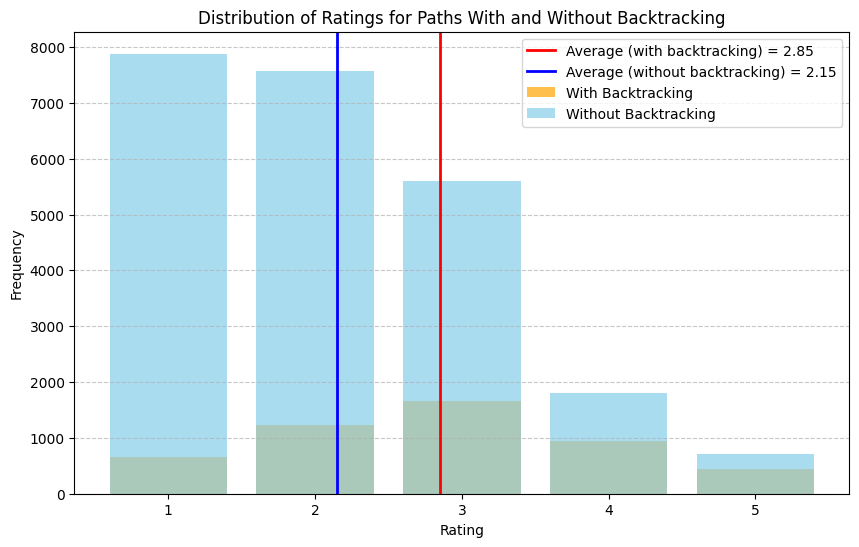

In [9]:
# Create mask for paths with backtracking and valid ratings
has_backtrack_mask = paths_finished['path'].str.contains('<')
has_rating_mask = paths_finished['rating'].notna()

# Filter ratings into two groups
ratings_with_backtrack = paths_finished.loc[has_backtrack_mask & has_rating_mask, 'rating']
ratings_without_backtrack = paths_finished.loc[~has_backtrack_mask & has_rating_mask, 'rating']

# Calculate averages using pandas methods
average_back = ratings_with_backtrack.mean()
average_no_back = ratings_without_backtrack.mean()

# Plot the histograms
plt.figure(figsize=(10, 6))

# Create bar plots with labels
plt.bar(ratings_with_backtrack.value_counts().index, 
        ratings_with_backtrack.value_counts().values,
        alpha=0.7, color='orange', label='With Backtracking')
plt.bar(ratings_without_backtrack.value_counts().index,
        ratings_without_backtrack.value_counts().values, 
        alpha=0.7, color='skyblue', label='Without Backtracking')

# Add vertical lines for the averages
plt.axvline(x=average_back, color='red', linestyle='-', linewidth=2, 
           label=f'Average (with backtracking) = {average_back:.2f}')
plt.axvline(x=average_no_back, color='blue', linestyle='-', linewidth=2,
           label=f'Average (without backtracking) = {average_no_back:.2f}')

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1,6))
plt.title('Distribution of Ratings for Paths With and Without Backtracking')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


One other indicator of player frustration we consider is the game’s "difficulty rating" assigned by the player upon completion. Generally, as the difficulty of a game increases, so does the rating, offering a potential correlation with the level of frustration experienced. If the player needs to backtrack, the perceived difficulty of the game seems higher.

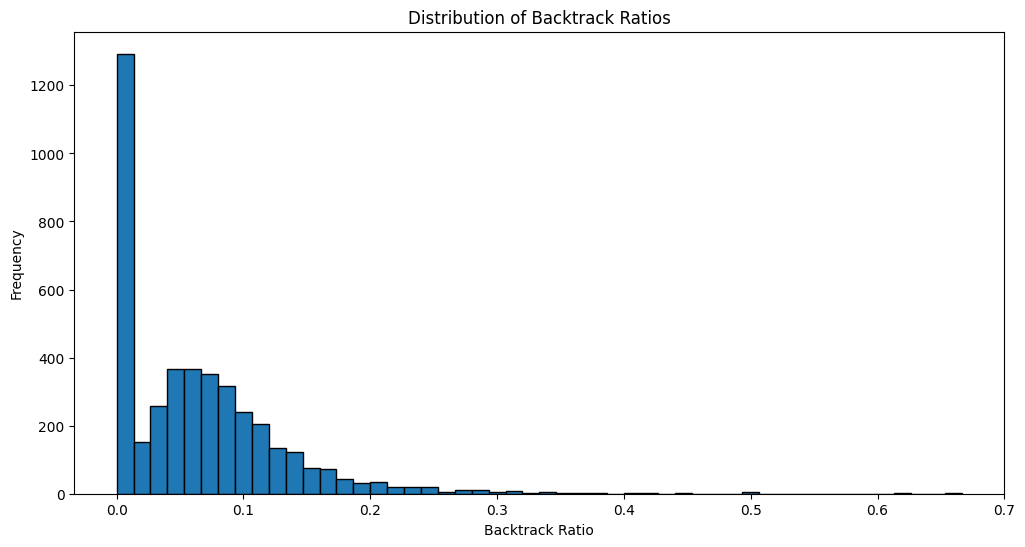

In [10]:

# Create a DataFrame with counts of backtracks and traversed
backtracks = pd.Series(all_paths['backtracks'].explode().dropna().tolist())
traversed = pd.Series(all_paths['traversed'].explode().dropna().tolist())

word_counts = pd.DataFrame({
    'backtracks': backtracks.value_counts(),
    'traversed': traversed.value_counts()
})

# Calculate the ratio of backtracks to traversed
word_counts['backtrack_ratio'] = word_counts['backtracks'] / word_counts['traversed']

# Fill NaN values with 0 (for words that were traversed but never backtracked)
word_counts['backtrack_ratio'] = word_counts['backtrack_ratio'].fillna(0)

# Sort by the ratio in descending order
word_counts_sorted = word_counts.sort_values('backtrack_ratio', ascending=False)

plt.figure(figsize=(12, 6))
plt.hist(word_counts['backtrack_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Backtrack Ratios')
plt.xlabel('Backtrack Ratio')
plt.ylabel('Frequency')
plt.show()



Most of the time, the player doesn't need to backtrack to finish the game, showing that the game seems to doable in a logic way. BUT, when the player needs to backtrack, the game is more difficult and the player rate it more negatively, hence creating frustration. That's where we want to focus our analysis.

# PARTIE SV TANIA EXPLICATION POURQUOI CA CREER FRUSTRATION

---

# Explanation

In [11]:
# Create DataFrame of backtrack-target pairs
backtrack_df = pd.DataFrame([
    {'backtrack': backtrack, 'target': row['target']}
    for _, row in all_paths[all_paths['backtracks'].apply(len) > 0][['backtracks','target']].iterrows()
    for backtrack in row['backtracks']
])

print("\nArticle of backtrack vs target")
print(backtrack_df.value_counts().head(20))



Article of backtrack vs target
backtrack         target     
Soybean           Bean           111
Herbivore         Zebra           89
Protein           Bean            62
Cell (biology)    Telephone       46
Sport             Tiger Woods     42
Salsa music       Bean            42
Coffee            Bean            38
Optical fiber     Telephone       37
Animal            Zebra           34
Mexico            Bean            34
Sound             Telephone       31
Internet          Telephone       30
Plant             Bean            30
Eye               Telephone       30
Computer science  Telephone       28
Food              Bean            27
Agriculture       Bean            26
Africa            Zebra           26
Jupiter           Viking          24
South Africa      Zebra           24
Name: count, dtype: int64


We’ve observed that numerous backtracks stem from confusion over closely related words or concepts. Could this reveal gaps or missing connections within the game’s design that prevent players from progressing/finishing?

In [12]:
# Find missing targets 
articles_set = set(articles['article'])
missing_targets = set([target for target in paths_unfinished['target'] if target not in articles_set])

if missing_targets:
    print("Missing targets:")
    for target in missing_targets:
        print(target)
else:
    print("No missing targets found.")


Missing targets:
Netbook
Rat
English
Sportacus
Black ops 2
Georgia
Mustard
Christmas
Long peper
Bogota
The Rock
Charlottes web
Rss
Podcast
Fats
Great
Adolph Hitler
Usa
Test
Western Australia
Macedonia
 Zebra
The
Kashmir


Indeed, there are missing connections—and, even more frustratingly, some destinations are entirely unreachable. Imagine the player’s frustration in searching for “Christmas,” only to complete the game on “Santa Claus” and realize there’s no link back to “Christmas.” This lack of connection not only disrupts gameplay but can also leave players feeling stuck and unsatisfied, amplifying their frustration.

---

# Solution

To assess if a link is needed between two articles and measure their "distance," we can use:

- **Shortest Path**: Count the hops between articles in the dataset. A high hop count suggests a possible need for a direct link.
- **Cosine Similarity**: Calculate similarity between article embeddings. High similarity without a link may indicate a need for connection.

# **But what is a cosine similarity ?**

Cosine similarity is a metric used to measure how similar two vectors are by focusing on their direction, not their magnitude. It’s commonly used in fields like natural language processing, recommendation systems, and machine learning.

## **How It Works**

**Vectors in Space**: 
   - Data points (e.g., text, documents) are represented as vectors in an n-dimensional space.

**Cosine of the Angle**:
   - Cosine similarity calculates the cosine of the angle between two vectors.
   - **Range**:
     - 1: Vectors are perfectly aligned (same direction).
     - 0: Vectors are orthogonal (no similarity).
     - -1: Vectors are opposite (complete dissimilarity, used in specific contexts).

**Formula**:
   $$
   \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
   $$

   - $\mathbf{A} \cdot \mathbf{B}$: Dot product of vectors $\mathbf{A}$ and $\mathbf{B}$.
   - $\|\mathbf{A}\|$: Magnitude (length) of vector $\mathbf{A}$.
   - $\|\mathbf{B}\|$: Magnitude of vector $\mathbf{B}$.

## **Why Use Cosine Similarity?**
- **Efficient to Compute**: No need to scale vectors; it inherently focuses on angles.
- **Insensitive to Magnitude**: Works well when vector magnitude is irrelevant (e.g., word frequency in text).
- **Widely Applicable**: Suitable for tasks like text similarity, clustering, and recommendation systems.


## **Now, the first step is to choose a model to embed our articles into vectors. Is there difference between models ? If so, which one should we choose ?**

Let's look at that game, it will also enable us to select which model we want to use for the rest of the analysis to compute the similarity between 2 articles :

/Users/hugo/miniconda3/envs/ada/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


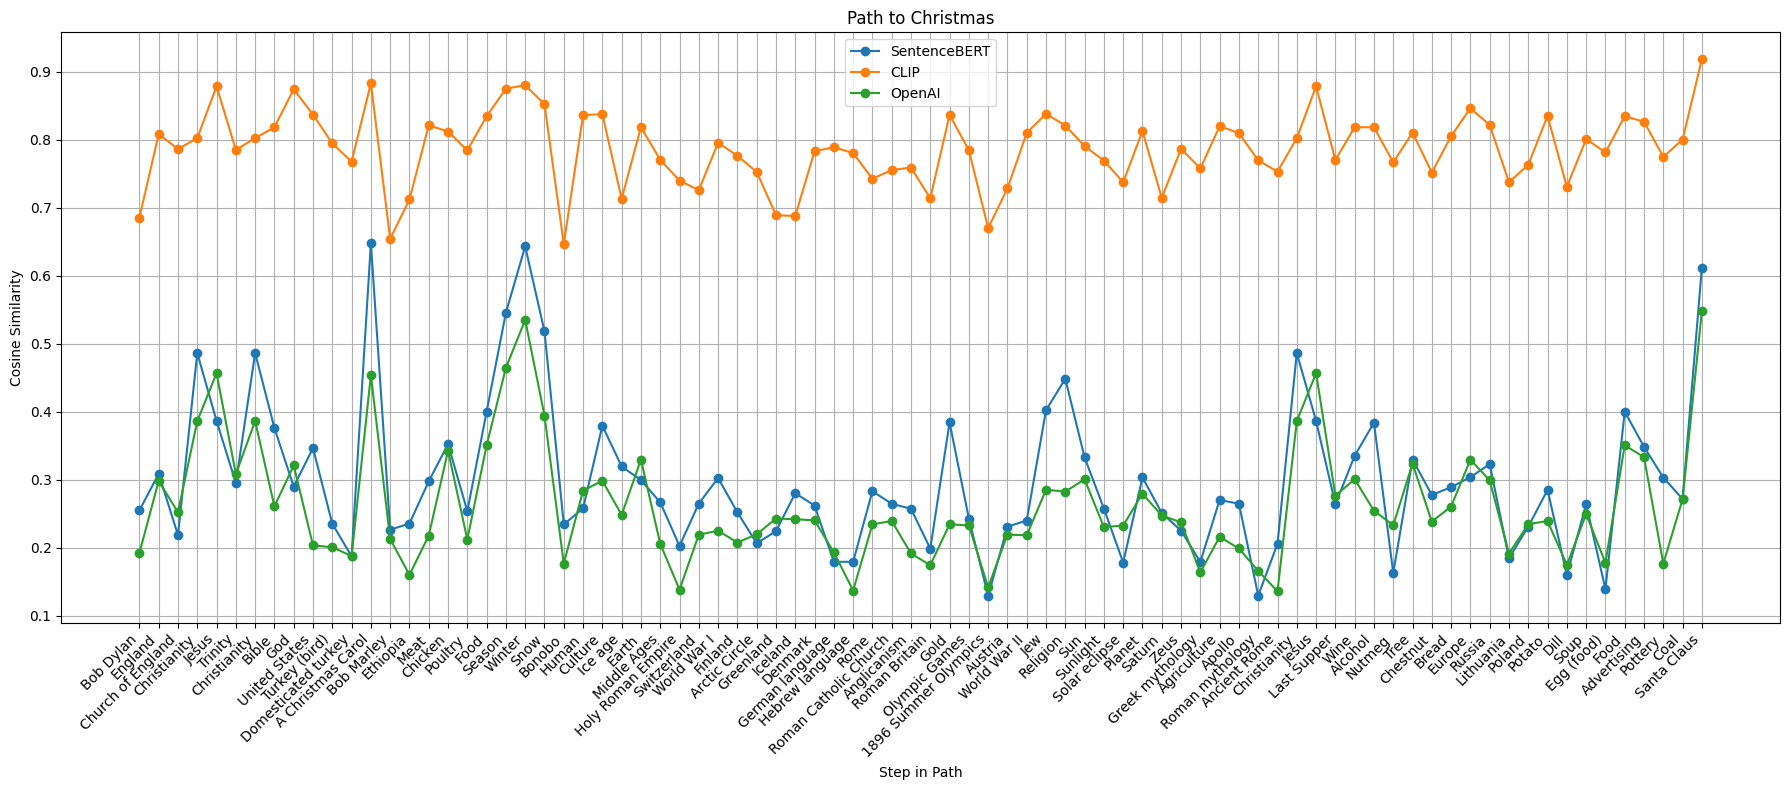

In [13]:
import torch
from sentence_transformers import SentenceTransformer, util
from src.utils.similarity import get_cosine_similarity_for_path_word_by_word, get_cosine_similarity_for_path_word_by_word_openai
from src.utils.utils import path_to_list

sb_model = SentenceTransformer("all-MiniLM-L6-v2", device="mps" if torch.backends.mps.is_available() else "cpu")
clip_model = SentenceTransformer("clip-ViT-B-32", device="mps" if torch.backends.mps.is_available() else "cpu")

christmas_path="Bob_Dylan;England;Church_of_England;Christianity;Jesus;Trinity;Christianity;Bible;God;United_States;Turkey_%28bird%29;Domesticated_turkey;A_Christmas_Carol;Bob_Marley;Ethiopia;Meat;Chicken;Poultry;Food;Season;Winter;Snow;Bonobo;Human;Culture;Ice_age;Earth;Middle_Ages;Holy_Roman_Empire;Switzerland;World_War_I;Finland;Arctic_Circle;Greenland;Iceland;Denmark;German_language;Hebrew_language;Rome;Roman_Catholic_Church;Anglicanism;Roman_Britain;Gold;Olympic_Games;1896_Summer_Olympics;Austria;World_War_II;Jew;Religion;Sun;Sunlight;<;Solar_eclipse;Planet;Saturn;Zeus;Greek_mythology;Agriculture;<;Apollo;Roman_mythology;Ancient_Rome;Christianity;Jesus;Last_Supper;Wine;Alcohol;<;Nutmeg;Tree;Chestnut;Bread;Europe;Russia;Lithuania;Poland;Potato;Dill;Soup;Egg_%28food%29;Food;Advertising;<;Pottery;Coal;Santa_Claus"
christmas_path = path_to_list(christmas_path)
bert_similarities = get_cosine_similarity_for_path_word_by_word(christmas_path, "Christmas", sb_model)
clip_similarities = get_cosine_similarity_for_path_word_by_word(christmas_path, "Christmas", clip_model)
openai_similarities = get_cosine_similarity_for_path_word_by_word_openai(christmas_path, "Christmas")


plt.figure(figsize=(18, 8))
plt.plot(range(len(christmas_path)), bert_similarities, marker='o', label='SentenceBERT')
plt.plot(range(len(christmas_path)), clip_similarities, marker='o', label='CLIP')
plt.plot(range(len(christmas_path)), openai_similarities, marker='o', label='OpenAI')
plt.title('Path to Christmas')
plt.xlabel('Step in Path') 
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()

plt.xticks(range(len(christmas_path)), christmas_path, rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define a function to evaluate similarity trends
def evaluate_similarity(similarities, path, target):
    # Identify indices where the path matches the target concept
    target_indices = [i for i, step in enumerate(path) if target.lower() in step.lower()]
    max_similarity = np.max(similarities)
    avg_similarity = np.mean(similarities)
    mse = mean_squared_error([max_similarity] * len(similarities), similarities)  # How consistent is the trend?
    return {
        "max_similarity": max_similarity,
        "avg_similarity": avg_similarity,
        "mse": mse,
        "target_indices": target_indices,
    }

# Evaluate all models
target = "Christmas"
sb_metrics = evaluate_similarity(bert_similarities, christmas_path, target)
clip_metrics = evaluate_similarity(clip_similarities, christmas_path, target)
openai_metrics = evaluate_similarity(openai_similarities, christmas_path, target)

# Print results
print("SentenceBERT Metrics:", sb_metrics)
print("CLIP Metrics:", clip_metrics)
print("OpenAI Metrics:", openai_metrics)



SentenceBERT Metrics: {'max_similarity': np.float64(0.6476807594299316), 'avg_similarity': np.float64(0.29899517265034886), 'mse': np.float64(0.13349142072598713), 'target_indices': [12]}
CLIP Metrics: {'max_similarity': np.float64(0.9184123873710632), 'avg_similarity': np.float64(0.787330505324573), 'mse': np.float64(0.02011459619699941), 'target_indices': [12]}
OpenAI Metrics: {'max_similarity': np.float64(0.5479663259905397), 'avg_similarity': np.float64(0.2630375129840482), 'mse': np.float64(0.08882119381541513), 'target_indices': [12]}


As we calculate the similarities with our three language models with a path to « Christmas », we can see CLIP has a mean similarity much higher than OpenAI and BERT, leading to more coherent results for OpenAI and BERT. This might suggest overgeneralization, where CLIP finds connections between "Christmas" and unrelated or less relevant concepts along the path. OpenAI and BERT produce more nuanced results. This means they assign higher similarity scores to steps more semantically relevant to "Christmas" (like "Santa Claus" or "A Christmas Carol") and lower scores to unrelated concepts. Both could be two good model choices, but since we have to choose one, we decided to deepen our analysis. As we compared OpenAI and BERT, we searched for two examples that could help us choose one: two paths, one for Charles Darwin and the other for George Washington. We compared their similarities with different centuries and see if one model has a better similarity for the century corresponding to our target. For Charles Darwin, OpenAI has a better similarity for the 19th century than SentenceBERT. For George Washington, SentenceBERT has a higher similarity for the 20th century than the 18th century. In contrast, OpenAI has its highest similarity for the 18th century corresponding to G.W. We then choose OpenAI because it has the best results for those examples and it’s trained with much larger data than SentenceBERT.

### First test of threshold to find missing links : Fixed threshold on the similarity

In [15]:
from src.utils.similarity import should_have_link

#using arbitrary threshold
print(should_have_link("Santa Claus","Christmas"))
print(should_have_link("Santa Claus","Summer"))
print(should_have_link("Soybean","Bean"))


(True, 0.5479663259905397)
(False, 0.21323512811689968)
(True, 0.4775772786481707)


In [16]:
# Find potential missing links between articles based on semantic similarity
should_link_dict = {}
missing_link_pairs = []

# Iterate through all articles
for source_article in tqdm(articles['article'][:100]):#only 100 articles to limit runtime
    # Get existing links from current article
    existing_links = links[links['linkSource'] == source_article]
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source_article.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()

    # Find articles that aren't currently linked from source article
    potential_targets = articles[~articles['article'].isin(existing_links['linkTarget'])]
    potential_targets = potential_targets[potential_targets['article'].str.lower().apply(lambda x: x in source_article_lowered)]
    potential_targets = potential_targets[potential_targets['article'].apply(lambda x: should_have_link(source_article,x)[0])]
    potential_targets = potential_targets[potential_targets['article'] != source_article]
    
    
    if len(potential_targets) > 0:
        should_link_dict[source_article]= potential_targets['article'].tolist()
        for target in potential_targets['article']:
            missing_link_pairs.append({
                'source': source_article,
                'target': target
            })


for article,targets in should_link_dict.items():
    print(f"{article}: {targets}")

pd.DataFrame(missing_link_pairs).to_csv('data/missing_links.csv', index=False)

100%|██████████| 100/100 [00:09<00:00, 10.62it/s]

Édouard Manet: ['Paul Cézanne']
Óengus I of the Picts: ['Picts']
€2 commemorative coins: ['Euro']
11th century: ['Middle Ages']
12th century: ['Middle Ages']
13th century: ['4th century', 'Crusades', 'Middle Ages']
14th century: ['4th century', '5th century']
19th century: ['Industrial Revolution']
1 Ceres: ['Ceres (dwarf planet)']
2004 Atlantic hurricane season: ['Hurricane Dennis']
21st century: ['1st century', '2nd century']
4 Vesta: ['Asteroid']
4th century: ['Constantine I']
90377 Sedna: ['Scattered disc']
AC DC: ['Alternating current']
AK-47: ['Firearm', 'Weapon']
ASCII: ['Algorithm', 'Alphabet', 'BASIC', 'Unix']
Aachen: ['Austria']
Aardvark: ['Ape']
Abacá: ['Manila']
Abacus: ['Algorithm']
Abbey Theatre: ['Abbey']
Abbot: ['Archbishop of Canterbury', 'Pope']
Abidjan: ['Ghana', 'Ivory']
Abkhazia: ['Armenia']
Absinthe: ['Alcohol', 'Wine']


In this initial iteration, the model appears to perform well, allowing us to easily add additional links. It identifies article titles mentioned within the text that are not yet linked, even when they are semantically close. 

---

# Is there a better way to do it ?

Let’s analyze the similarities across the entire game by calculating the similarity between each page and the target article.

In [17]:
all_path_similarities_unfinished, all_path_similarities_finished = data_loader.load_all_path_similarities()

In [18]:
# Take only the last 10 elements of each path
from src.utils.utils import shorten_list_finished, shorten_list_unfinished

all_path_similarities_unfinished_copy = all_path_similarities_unfinished.copy()
all_path_similarities_unfinished_copy['similarities'],all_path_similarities_unfinished_copy['path'] = zip(*all_path_similarities_unfinished_copy.apply(shorten_list_unfinished, axis=1))

similarities_unfinished = all_path_similarities_unfinished_copy[all_path_similarities_unfinished_copy['similarities'].apply(lambda x: len(x) > 0)][['similarities','path','target']]


all_path_similarities_finished_copy = all_path_similarities_finished.copy()
all_path_similarities_finished_copy['similarities'],all_path_similarities_finished_copy['path'] = zip(*all_path_similarities_finished_copy.apply(shorten_list_finished, axis=1))
similarities_finished = all_path_similarities_finished_copy['similarities']

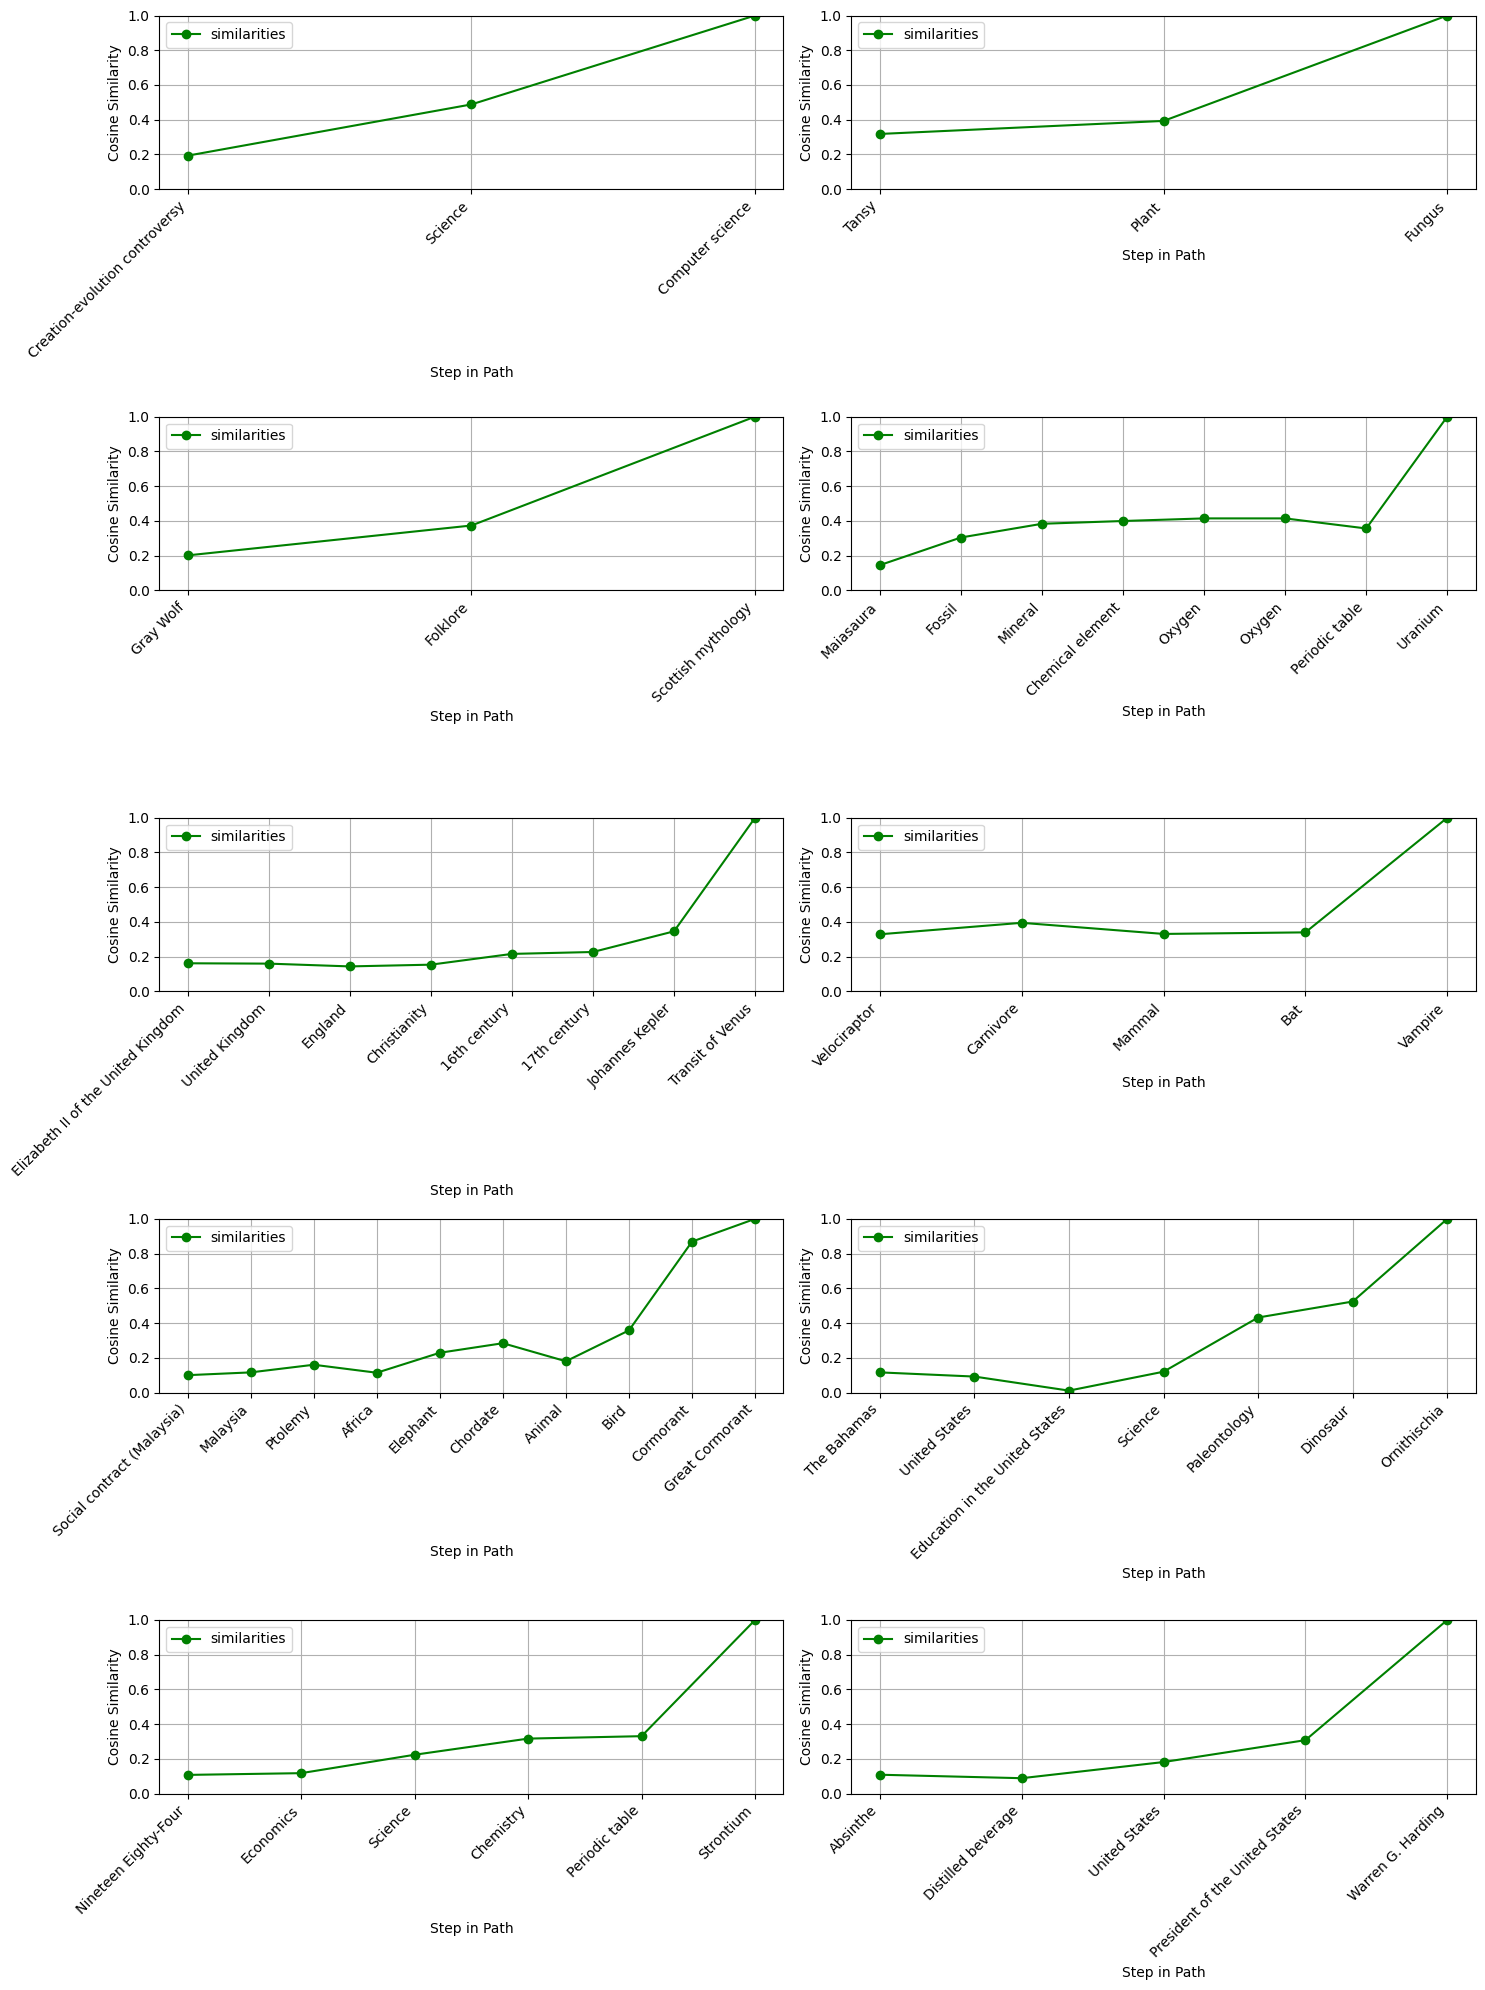

In [19]:
# Create a figure with subplots for the first 20 paths (10x2 grid)
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

# Colors for each model
colors = {
    'similarities': 'green'
}
sample_size = 10

selected_finished = all_path_similarities_finished_copy.sample(sample_size)

# Generate individual plots
for i in range(sample_size):
    ax = axes[i]
    
    path = selected_finished.apply(lambda x: x['path'],axis=1).iloc[i]
    target = selected_finished['target'].iloc[i]
    
    # Plot similarities
    similarities = selected_finished.apply(lambda x: x['similarities'],axis=1).iloc[i]
    ax.plot(range(len(similarities)), similarities,
            marker='o', label='similarities', color=colors['similarities'])
    
    # Customize the plot
    #ax.set_title(f'Path {i+1}\nTarget: {target}')
    ax.set_xlabel('Step in Path')
    ax.set_ylabel('Cosine Similarity')
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend()
    
    # Add path words as x-tick labels
    ax.set_xticks(range(len(path)))
    ax.set_xticklabels(path, rotation=45, ha='right')

plt.tight_layout()
plt.show()


Mhhhhh, it seems like there is a trend over there !!

# Plot similarity evolution for 100 paths together

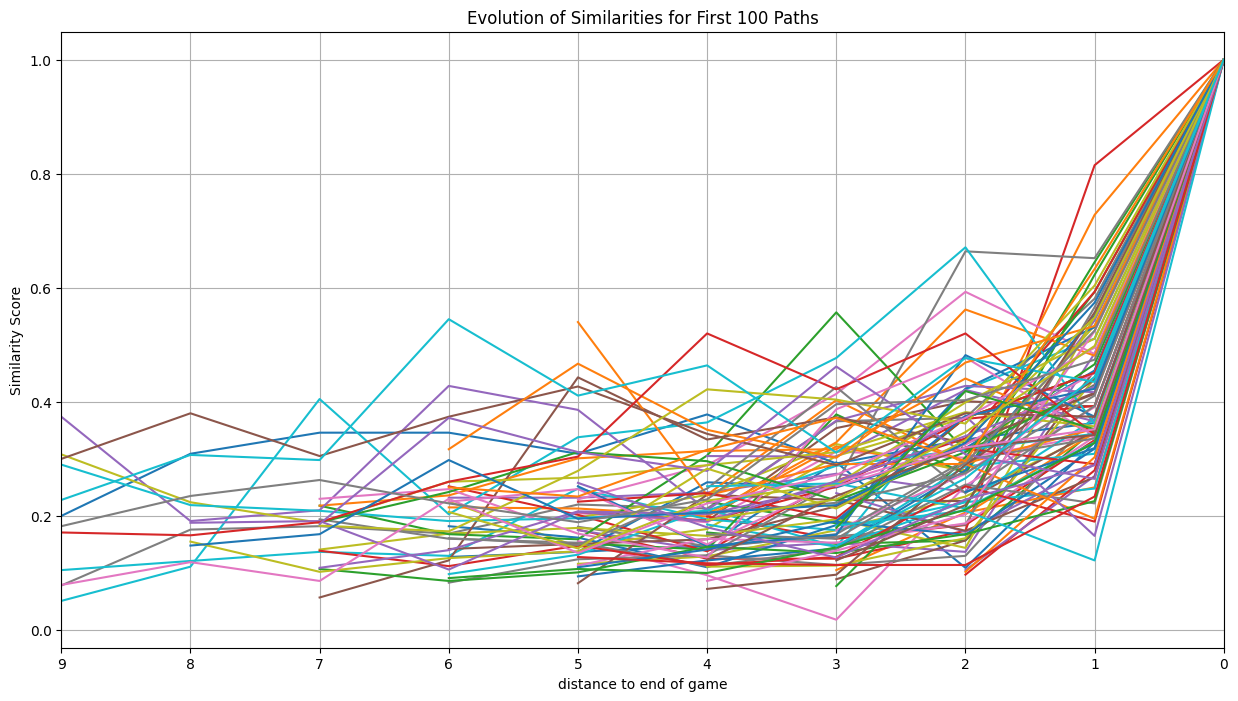

In [20]:
plt.figure(figsize=(15, 8))

# Plot first 100 similarity evolutions
random_finished = all_path_similarities_finished_copy.sample(100)
for index, path in random_finished.iterrows():
    similarities = path['similarities']
    reversed_similarities = similarities[::-1]
    plt.plot(reversed_similarities)


plt.xlabel('distance to end of game')
plt.ylabel('Similarity Score') 
plt.xlim(9,0)
plt.title('Evolution of Similarities for First 100 Paths')

# Add grid for better readability
plt.grid(True)

plt.show()


Across all completed games, we observe a clear trend in the endgame stage. Let’s examine whether this trend extends to unfinished games as well (excluding the final step, of course).

In [21]:
from src.utils.similarity import process_similarities

similarities_by_distance_finished = process_similarities(similarities_finished)
similarities_by_distance_unfinished = process_similarities(similarities_unfinished['similarities'])

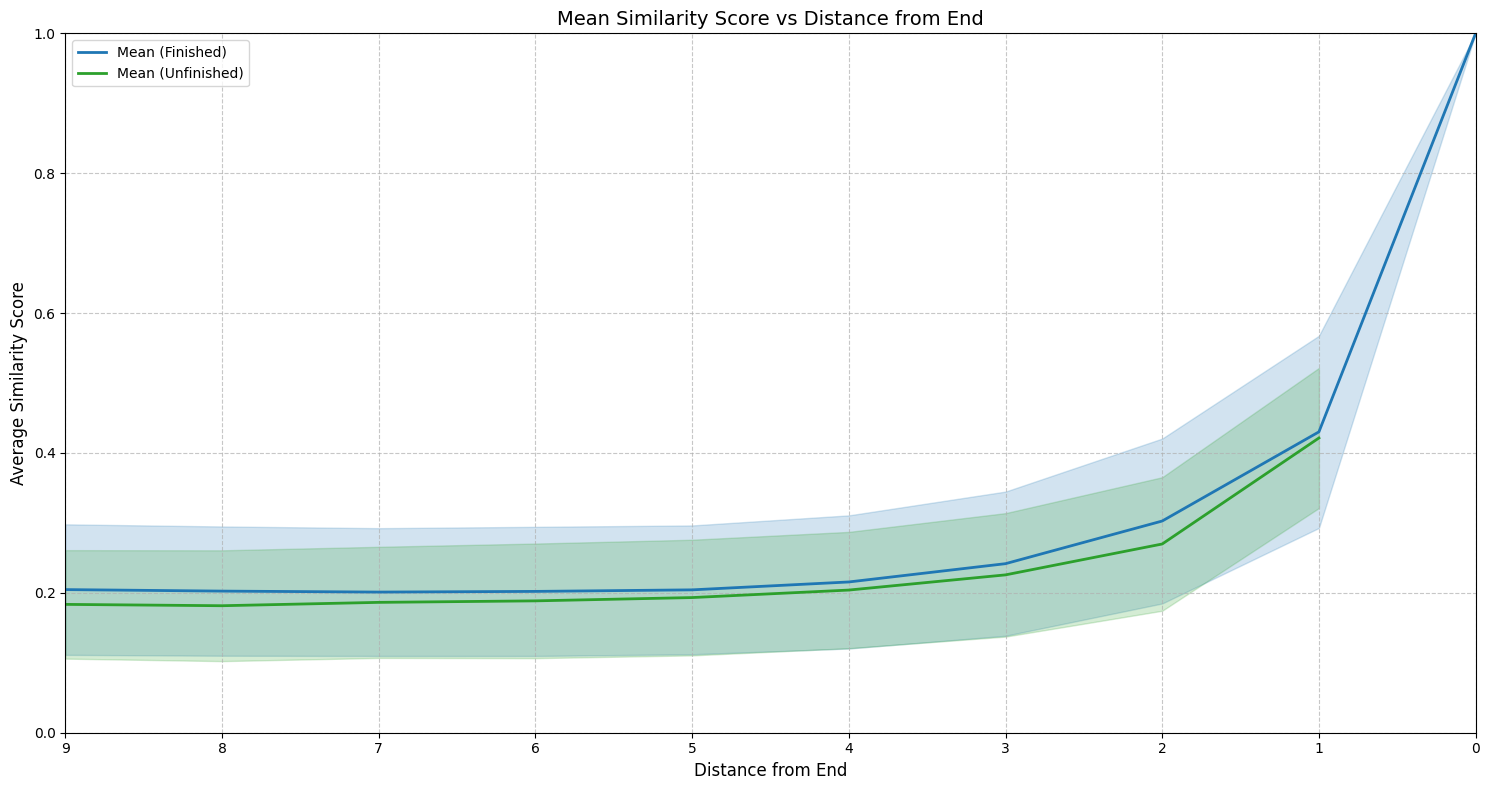

In [22]:
# Calculate means, medians, and standard deviations
stats = {
    'Finished': [similarities_by_distance_finished, range(10)],
    'Unfinished': [similarities_by_distance_unfinished, range(1,10)]
}

plt.figure(figsize=(15, 8))
colors = ['#1f77b4', '#2ca02c']

for i, (path_type, (similarities, x)) in enumerate(stats.items()):
    means = [np.mean(sublist) for sublist in similarities]
    stds = [np.std(sublist) for sublist in similarities]
    
    plt.plot(x, means, color=colors[i], label=f'Mean ({path_type})', linewidth=2)
    plt.fill_between(x, [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     color=colors[i], alpha=0.2)

plt.xlabel('Distance from End', fontsize=12)
plt.ylabel('Average Similarity Score', fontsize=12)
plt.ylim(0,1)
plt.xlim(9,0)
plt.title('Mean Similarity Score vs Distance from End', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


Our analysis confirms a trend in the endgame stage, even within unfinished paths. To investigate this, we focused on the highest similarity point within each game and the last eight moves leading up to it. This trend reveals several possible scenarios:

- **Player Confusion**: Some players appear to struggle, failing to reach a similarity threshold of 0.3. In such cases, the game might be disregarded by the search algorithm, as the low similarity indicates a lack of meaningful progression.

- **Missed Links**: Players may overlook critical links if they appear later in the article rather than at the beginning. This suggests a potential improvement area in link placement to aid player navigation. (Refer to the accompanying graph for a visual representation.)

- **Missing Final Link**: In some cases, there may be a missing link between the last article the player reached and the target, creating a gap in progression and heightening player frustration.

In [23]:
from src.utils.utils import get_missing_links

unfinished_missing_links = similarities_unfinished.apply(get_missing_links,axis=1)
print("Most common pairs of articles that may be missing links:")
print(unfinished_missing_links.value_counts().head(20))


Most common pairs of articles that may be missing links:
biggest_similarity_article  target              
Soybean                     Bean                    210
Internet                    Telephone               125
Africa                      Zebra                    78
Animal                      Zebra                    73
India                       Economy of India         71
Shark                       Nurse sharks             53
Food                        Bean                     49
Giraffe                     Zebra                    49
Norse mythology             Viking                   40
Plant                       Bean                     39
Technology                  Telephone                39
Human                       Telephone                38
Batman                      Penguin                  33
Cat                         Computer                 33
Coffee                      Bean                     32
Canadian Senate             Senate of Canada         3

In [24]:
# Filter pairs that appear at least 2 times
frequent_pairs = unfinished_missing_links.value_counts()[unfinished_missing_links.value_counts() >= 2]
link_missed_by_player = []
link_absent = []

for source, target in frequent_pairs.index:
    full_source_article = open(f"data/plaintext_articles/{urllib.parse.quote(source.replace(' ', '_'))}.txt","r").read()
    source_article_lowered = full_source_article.lower()
    if links[(links['linkSource'] == source) & (links['linkTarget'] == target)].shape[0] > 0:
        link_missed_by_player.append((source,target))
    elif target.lower() in source_article_lowered:
        link_absent.append((source,target))


print(f"Link missed by player: {len(link_missed_by_player)}")
print(f"Link absent: {len(link_absent)}")

# Save missing links to CSV
missing_links_df = pd.DataFrame(link_absent, columns=['source', 'target'])
missing_links_df.to_csv('data/missing_links.csv', index=False)

# Save links missed by players to CSV 
missed_by_player_df = pd.DataFrame(link_missed_by_player, columns=['source', 'target'])
missed_by_player_df.to_csv('data/links_missed_by_player.csv', index=False)

Link missed by player: 96
Link absent: 217


## But why is there some links missed by the player ? 

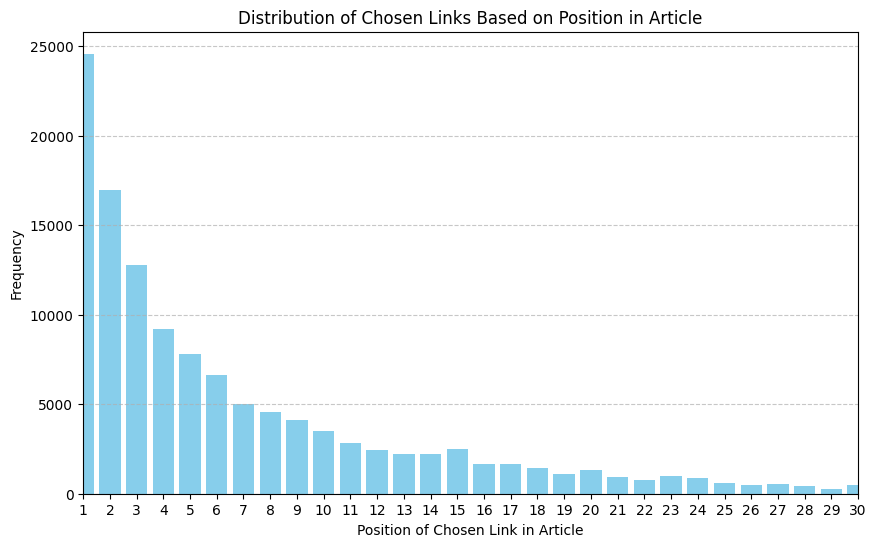

In [25]:
chosen_links_df =pd.read_csv('data/chosen_links_rank.csv')

rank_data = chosen_links_df['RankChosen'].dropna()

# Count the frequency of each rank
rank_counts = rank_data.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(rank_counts.index, rank_counts.values, color='skyblue')
plt.xlabel('Position of Chosen Link in Article')
plt.xlim(1, 30)  # Limit to first 20 positions
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Links Based on Position in Article')

# Set x-ticks to show every position within the limited range
plt.xticks(range(1, 31))  

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### A reason could be that player seems to target more the first link in the article, the further the link is, the less susceptible to be chosen.

---

## **Quick look at the state of the game currently :**

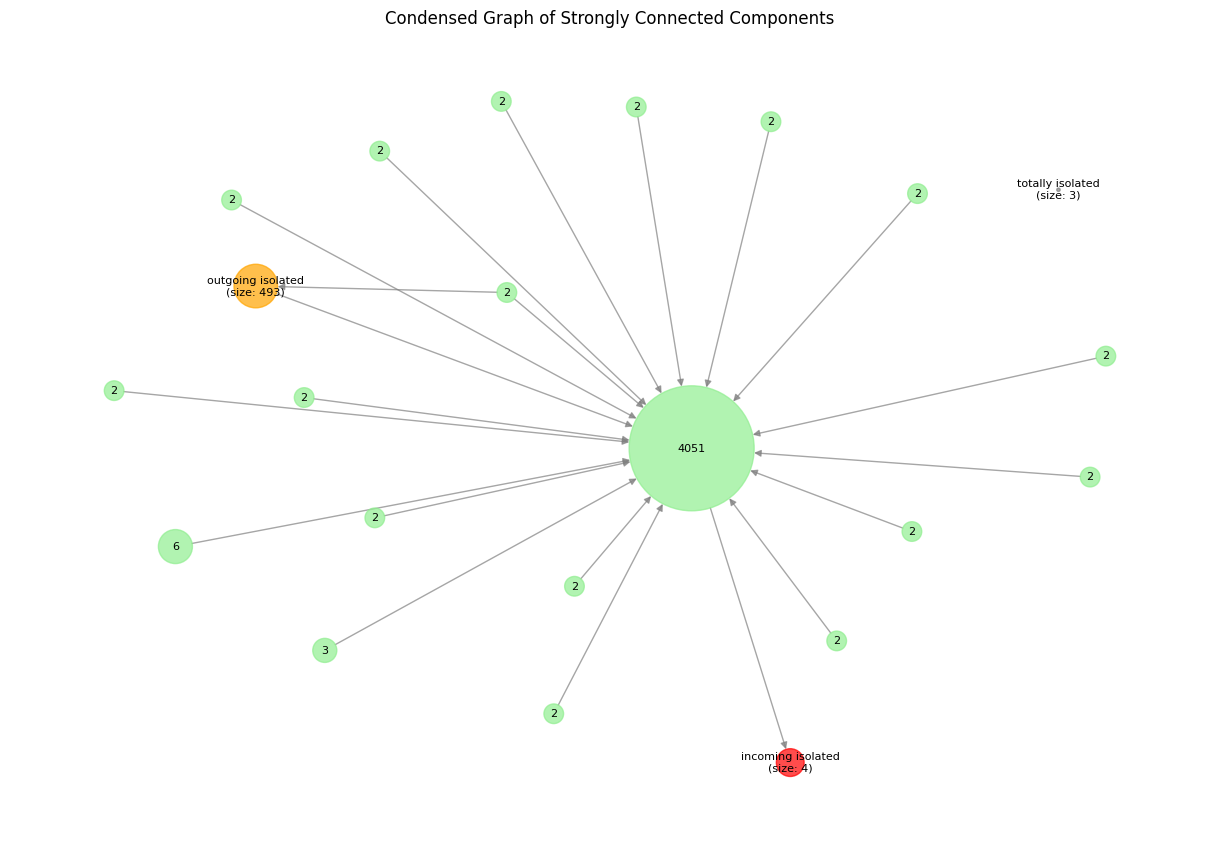

In [27]:
from src.utils.visu_paths_3D import visualize_path, draw_condensed_graph, visualize_path_2D
G = nx.DiGraph()
for _, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])
G_closest_neighbors = G.copy()
draw_condensed_graph(G)

As we can see, there is a big cluster containing most of the articles that can be mutually reached. But there is still more than 500 articles (around 12% of the articles) that are either not reachable from any other article or that can't reach most articles.

Our goal is to make every article reachable from any starting point, enhancing the game's playability while preserving its core challenge. We'll focus on adding only the most essential connections - those that users naturally expect to find - rather than artificially flooding the network with links.

915it [00:00, 69927.99it/s]


Added 915 edges


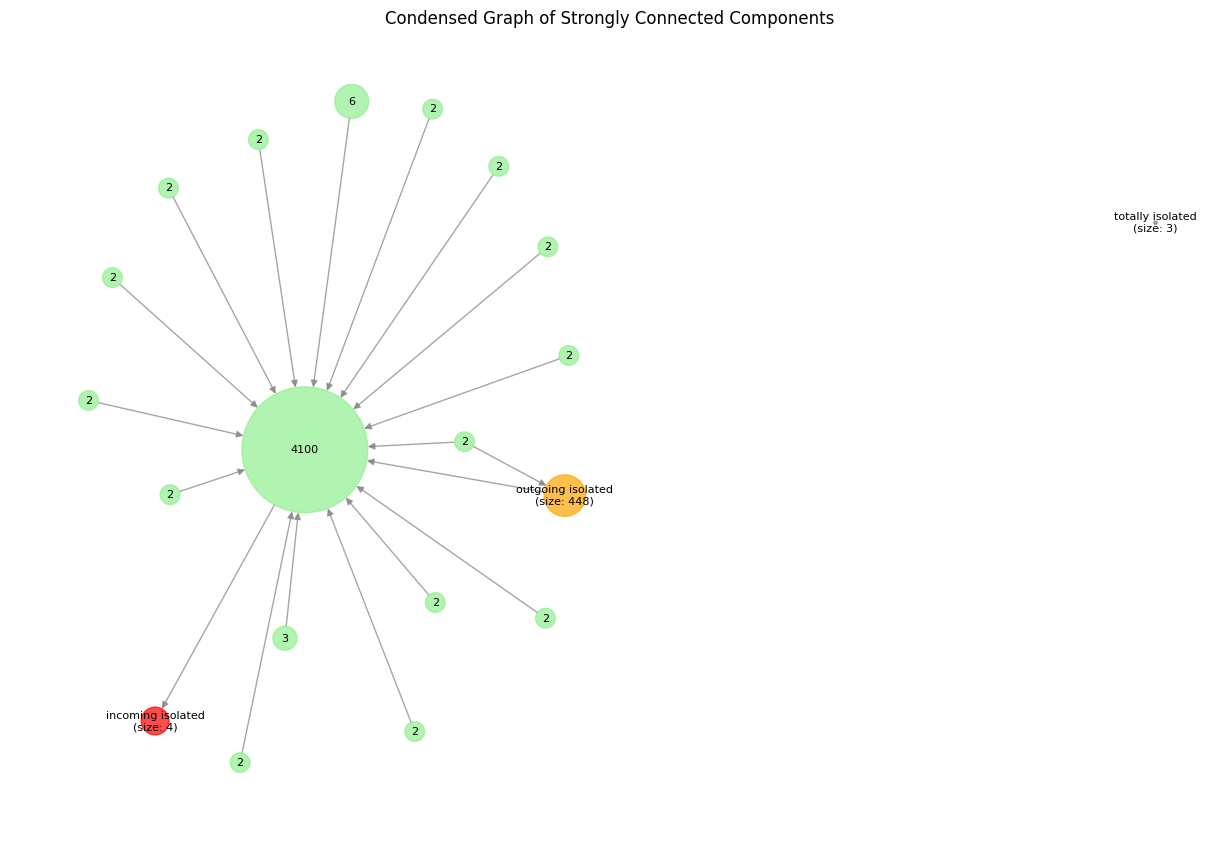

In [28]:
#Add edges from missing_links_but_present.csv

missing_links_but_present = pd.read_csv('data/missing_links_but_present.csv')
G_missing_high_similarity = G.copy()
strongly_connected_components = list(nx.strongly_connected_components(G_missing_high_similarity))
largest_component = strongly_connected_components[max(range(len(strongly_connected_components)), key=lambda x: len(strongly_connected_components[x]))]

i = 0
for _, row in tqdm(missing_links_but_present.iterrows()):
    G_missing_high_similarity.add_edge(row['target_article'], row['source_article'])
    i += 1

print(f"Added {i} edges")

draw_condensed_graph(G_missing_high_similarity)

The graph above visualizes the network structure after implementing our semantic similarity-based link additions.

While this improvement is modest - only 49 additional articles joined the main cluster - it confirms our hypothesis that some disconnected articles are semantically related and referenced within each other. However, the small increase also suggests that we need additional strategies to significantly improve the network's connectivity. 

We then tried a less restrictive approach: add a link whenever one article's name appears in another's content, regardless of semantic similarity.

372813it [00:04, 76746.86it/s]


Added 372813 edges


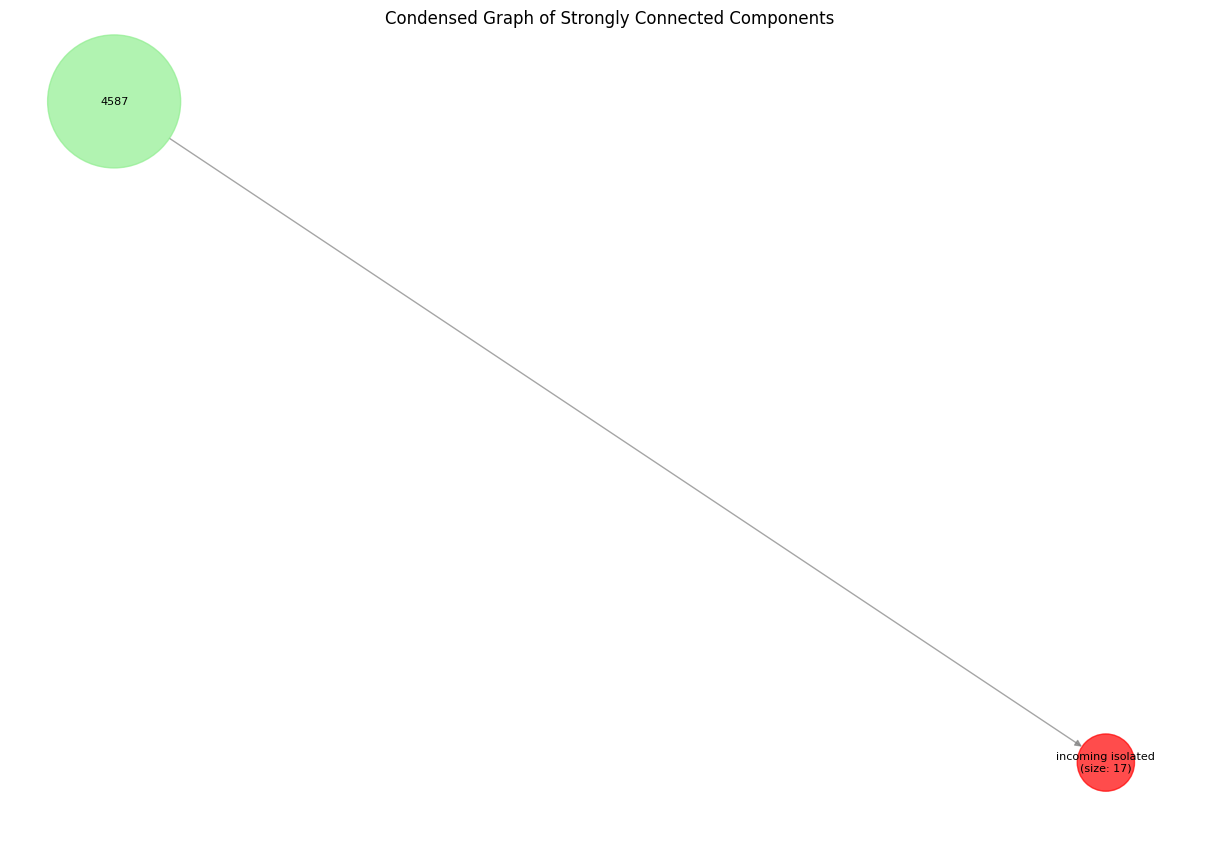

In [29]:
#Add edges from missing_links_but_present_all_complete_full_integral.csv
missing_links_but_present = pd.read_csv('data/missing_links_but_present_all_complete_full_integral.csv')
G_missing_all = G.copy()

i = 0
for _, row in tqdm(missing_links_but_present.iterrows()):
    G_missing_all.add_edge(row['target_article'], row['source_article'])
    i += 1
    

print(f"Added {i} edges")

draw_condensed_graph(G_missing_all)

# Adds to much links to the graph -> more than 372 000 edges

This approach dramatically improved connectivity, but at a severe cost: it added 372,813 new links—more than quintupling the total number of connections in the network. Such a dense web of links would fundamentally change the nature of Wikispeedia, making it too easy to find connections and removing the creative challenge that makes the game engaging.

This reveals an important tension in our mission: while we want to make the game more accessible by eliminating impossible paths, we must be careful not to sacrifice the core gameplay experience that makes Wikispeedia both challenging and rewarding.

## **Finding missing links in an efficient way**


But is this even possible ? Can we find a way to find missing links without adding too much links ? Maybe there is an article that is so specific that it would make no sense to even try to connect it to other articles. To elucidate this, we decided to plot the embeddings of all articles (by reducing the dimensionality of the embeddings to 2 dimensions using t-SNE) and see if there are any completely isolated articles, especially words that are not in the main cluster.

In [30]:
all_words_df = pd.read_csv('data/all_words_df.csv')
all_words_df['embedding'] = all_words_df['embedding'].apply(
    lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x)
)

# Filter out rows where 'encoded_version' is still invalid (e.g., not arrays)
all_words_df = all_words_df.dropna(subset=['embedding'])

embeddings = np.vstack(all_words_df['embedding'].values)
tsne = TSNE(n_components=2, random_state=42)
tsne3D = TSNE(n_components=3, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)
reduced_embeddings3D = tsne3D.fit_transform(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:

strongly_connected_components = list(nx.strongly_connected_components(G_closest_neighbors))
largest_component = strongly_connected_components[max(range(len(strongly_connected_components)), key=lambda x: len(strongly_connected_components[x]))]
largest_component_words = set(largest_component)
# Create masks for isolated in/out words
isolated_mask = ~all_words_df['article'].isin(largest_component_words)

# Create visualization using plotly
import plotly.express as px
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scatter plots for both groups
fig.add_trace(go.Scatter(
    x=reduced_embeddings[~isolated_mask, 0],
    y=reduced_embeddings[~isolated_mask, 1],
    mode='markers',
    name='Other words',
    marker=dict(
        color='light grey',
        size=5,
        opacity=0.5
    ),
    text=all_words_df[~isolated_mask]['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title="Highlighting Isolated Words",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    hovermode='closest',
    width=800,
    height=600
)

fig.show()


Interestingly, the visualization reveals that there are no truly semantically isolated articles - even the currently disconnected articles (shown in red) are semantically similar to some connected articles (in blue), as evidenced by their proximity in the semantic space. This suggests that the current disconnections in the network are more a result of missing links rather than fundamental semantic incompatibility between articles.

To be able to connect all articles, we devised an algorithm that would, at each step, add a link between the isolated article that is the most similar to any article in the main cluster and this article of the main cluster. So the selected article (and articles connected to it) would now be part of the main cluster. We repeated this process until all articles were connected.

Due to run Time we can't do the Region Growing alforithm here, but you can see it in data/generate_links.py
Here we just load "closest_neighbors_df" which is the result of the Region Growing algorithm.


In [32]:
# Create a figure for visualizing the links
closest_neighbors_df = pd.read_csv('data/closest_neighbors.csv')
isolated_mask = ~all_words_df['article'].isin(largest_component_words)
fig = go.Figure()

# Plot all points
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers',
    name='All Words',
    marker=dict(
        color='lightgray',
        size=5,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=reduced_embeddings[isolated_mask, 0],
    y=reduced_embeddings[isolated_mask, 1],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=5
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Add lines for links where words are present in articles
for _, row in closest_neighbors_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source_article']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target_article']].index[0]
    
    fig.add_trace(go.Scatter(
        x=[reduced_embeddings[source_idx, 0], reduced_embeddings[target_idx, 0]],
        y=[reduced_embeddings[source_idx, 1], reduced_embeddings[target_idx, 1]],
        mode='lines',
        line=dict(color='green', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(
    title="Word Embeddings with Links in 2D",
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    showlegend=True,
    width=800,
    height=600
)

fig.show()



In [33]:
#in 3D because it looks good
# Create a figure for visualizing the links in 3D
isolated_mask = ~all_words_df['article'].isin(largest_component_words)
fig = go.Figure()

# Plot all points in 3D
fig.add_trace(go.Scatter3d(
    x=reduced_embeddings3D[:, 0],
    y=reduced_embeddings3D[:, 1],
    z=reduced_embeddings3D[:, 2],
    mode='markers',
    name='All Words',
    marker=dict(
        color='blue',
        size=3,
        opacity=0.5
    ),
    text=all_words_df['article'],
    hoverinfo='text'
))

fig.add_trace(go.Scatter3d(
    x=reduced_embeddings3D[isolated_mask, 0],
    y=reduced_embeddings3D[isolated_mask, 1],
    z=reduced_embeddings3D[isolated_mask, 2],
    mode='markers',
    name='Isolated',
    marker=dict(
        color='red',
        size=3
    ),
    text=all_words_df[isolated_mask]['article'],
    hoverinfo='text'
))

# Add lines for links where words are present in articles
for _, row in closest_neighbors_df.iterrows():
    source_idx = all_words_df[all_words_df['article'] == row['source_article']].index[0]
    target_idx = all_words_df[all_words_df['article'] == row['target_article']].index[0]
    
    fig.add_trace(go.Scatter3d(
        x=[reduced_embeddings3D[source_idx, 0], reduced_embeddings3D[target_idx, 0]],
        y=[reduced_embeddings3D[source_idx, 1], reduced_embeddings3D[target_idx, 1]],
        z=[reduced_embeddings3D[source_idx, 2], reduced_embeddings3D[target_idx, 2]],
        mode='lines',
        line=dict(color='green', width=1),
        showlegend=False,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(
    title="3D Word Embeddings with Links",
    scene=dict(
        xaxis_title="Dimension 1",
        yaxis_title="Dimension 2",
        zaxis_title="Dimension 3"
    ),
    showlegend=True,
    width=800,
    height=600
)

fig.show()


## **How is the game connected now ?**

553it [00:00, 64136.99it/s]

Added 553 edges


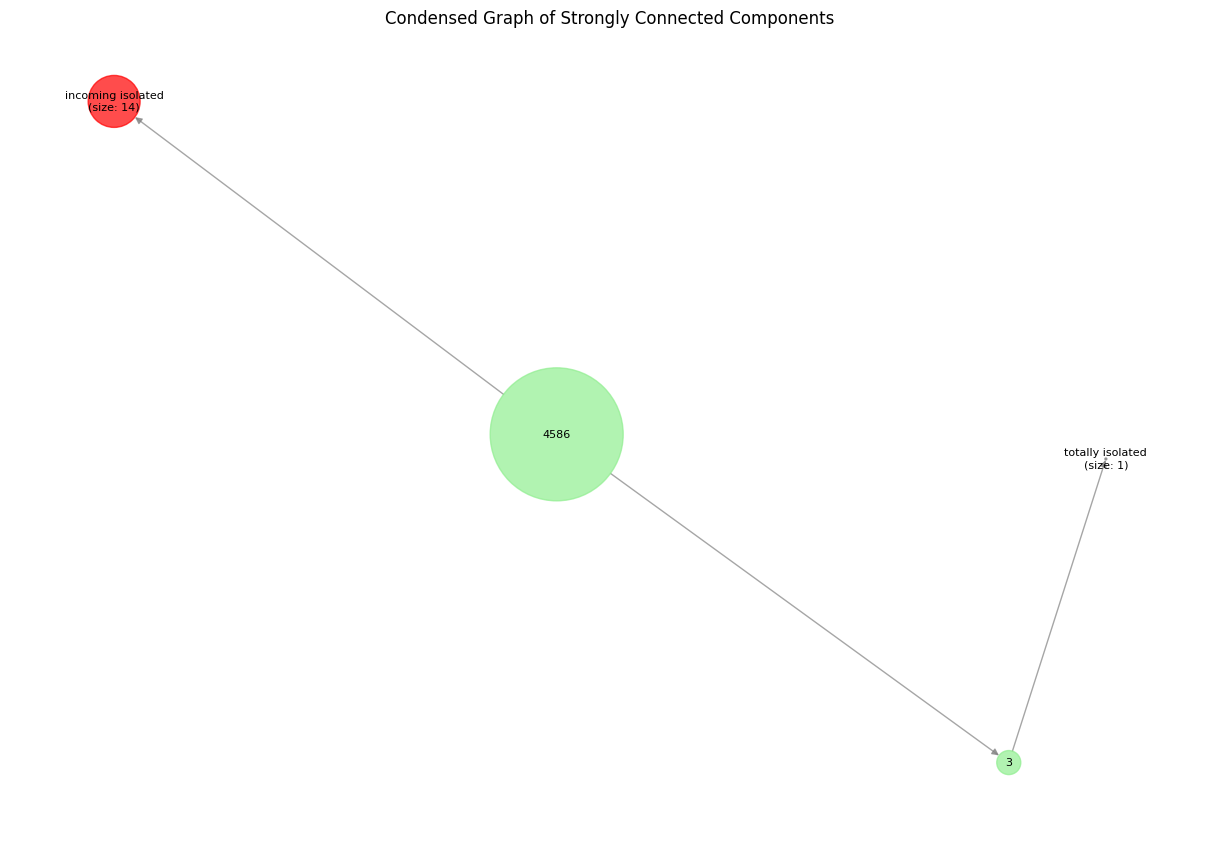

In [34]:
missing_links_but_present = pd.read_csv('data/closest_neighbors.csv')
G_closest_neighbors = G.copy()
strongly_connected_components = list(nx.strongly_connected_components(G_closest_neighbors))
largest_component = strongly_connected_components[max(range(len(strongly_connected_components)), key=lambda x: len(strongly_connected_components[x]))]

i = 0
for _, row in tqdm(missing_links_but_present.iterrows()):
    
    G_closest_neighbors.add_edge(row['target_article'], row['source_article'])
    i += 1
    # if row['source_article'] in largest_component and not row['target_article'] in largest_component:
    #     #print(f"Adding edge {row['source_article']}(main) -> {row['target_article']}(isolated)")
    #     G.add_edge(row['source_article'], row['target_article'])
    #     i += 1
    # elif row['target_article'] in largest_component and not row['source_article'] in largest_component:
    #     #print(f"Adding edge {row['source_article']}(isolated) -> {row['target_article']}(main)")
    #     G.add_edge(row['source_article'], row['target_article'])
    #     i += 1

print(f"Added {i} edges")


draw_condensed_graph(G_closest_neighbors)

The visualization above represents a remarkable achievement: we've successfully connected all 4,604 articles into a single strongly connected component. This means every article is now reachable from any other article, creating a fully navigable network. What's particularly impressive is that we achieved this with only 525 carefully chosen additional links - a mere fraction of the potential connections we could have added.

The single green circle in the graph, labeled "4604", represents this unified network where all articles are mutually accessible. This is in stark contrast to the initial fragmented state we saw earlier, where many articles were isolated or part of disconnected components. Our selective approach to adding links has maintained the game's challenge while eliminating impossible paths.

## **Analysis of the links we generated**

Does they makes sense ?  How can we analyze them ? 


In [35]:
analysis_df = pd.read_csv('data/analysis_df.csv')
print(analysis_df[['source_article','target_article','semantic_distance']].sort_values(by='semantic_distance',ascending=False).head())

                       source_article                    target_article  \
0    Polish–Muscovite War (1605–1618)  Polish-Muscovite War (1605–1618)   
1                             Bahamas                       The Bahamas   
2              Cleopatra VII of Egypt                     Cleopatra VII   
4                         HD 217107 c                       HD 217107 b   
151                          Blue Tit                         Great Tit   

     semantic_distance  
0                0.977  
1                0.944  
2                0.927  
4                0.915  
151              0.883  


The highest-similarity connections are extremely intuitive - many are simply different names for the same concept or closely related species. These links are so natural that their absence from the original network seems more like an oversight than a deliberate choice.

In [36]:
print(analysis_df[['source_article','target_article','semantic_distance']].sort_values(by='semantic_distance',ascending=True).head())

                     source_article     target_article  semantic_distance
552                         FairTax       Minimum wage              0.313
551    The Famous Five (characters)       Little Women              0.330
550  Forensic facial reconstruction  Tooth development              0.331
548                   Schatzki ring    Crohn's disease              0.333
547      Julius and Ethel Rosenberg   Romeo and Juliet              0.336


Even the lower-similarity connections maintain some logical relationship - they connect articles within similar domains (literature, medical conditions, economic policy) while still requiring players to think creatively about the connections. This preserves the game's challenge while eliminating truly impossible paths.

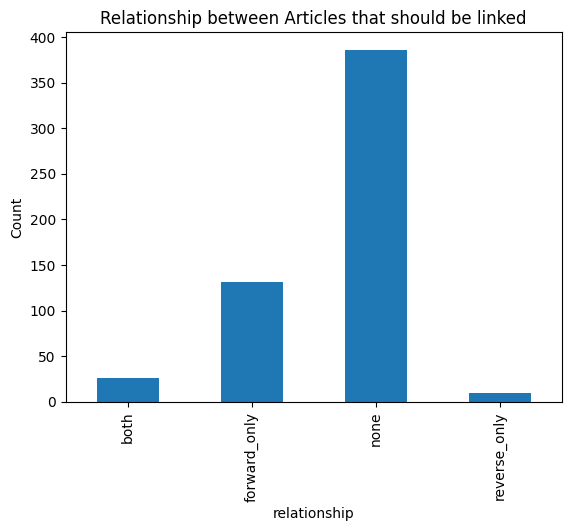

In [37]:
#add legend
#title and labels
plt.title('Relationship between Articles that should be linked')
plt.xlabel('Relationship')
plt.ylabel('Count')
analysis_df.groupby('relationship').size().plot(kind='bar')
plt.show()

### Both means that the other word is present in the article of the source word and vice versa.
### Forward only means that the other word is present in the article of the source word.
### Reverse only means that the source word is present in the article of the other word.
### None means that the other word is not present in the article of the source word.

In [38]:
analysis_df['target_article'].value_counts()

target_article
List of countries     6
European Goldfinch    4
Sundew                3
Chiltern Hills        3
Allosaurus            3
                     ..
Cape Lion             1
Nobiin language       1
Boeing 747            1
Eurasian Eagle Owl    1
Minimum wage          1
Name: count, Length: 486, dtype: int64

### Some articles seem to be the prefered link for many words, Thus showing that "Hub" articles can be improved by adding more information to them. Perhaps showing that the choice made by the creator of the game is not optimal.

---

# But how our links compared to the original ones already in the game ? 

In [39]:
article_similarities = pd.read_csv('data/article_similarities_matrix.csv')

one_way_distances = pd.read_csv('data/one_way_distances.csv')['semantic_distance']
two_way_distances = pd.read_csv('data/two_way_distances.csv')['semantic_distance']


In [40]:
print(f"One-way edges: {len(one_way_distances)}")
print(f"Two-way edges: {len(two_way_distances)}")

One-way edges: 93302
Two-way edges: 26580


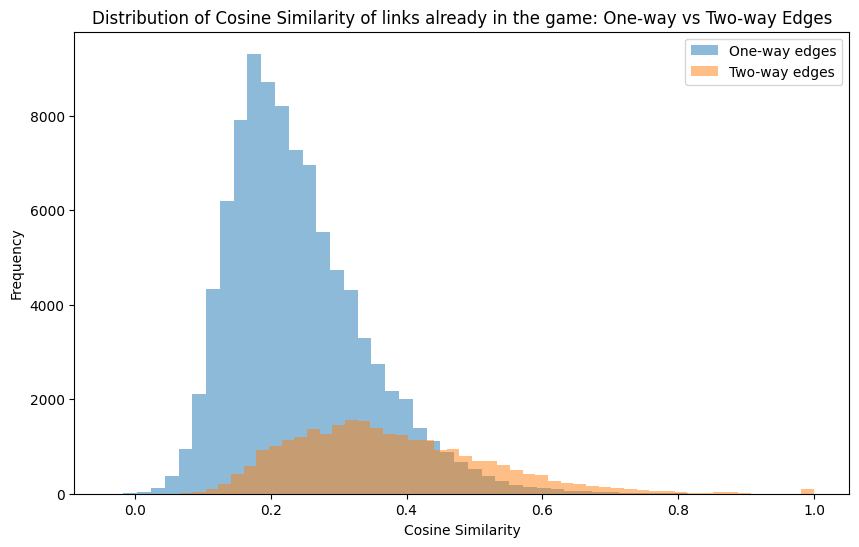

One-way edges statistics:
Mean distance: 0.240
Median distance: 0.223
Std deviation: 0.100

Two-way edges statistics:
Mean distance: 0.374
Median distance: 0.353
Std deviation: 0.144


In [41]:
# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(one_way_distances, alpha=0.5, label='One-way edges', bins=50)
plt.hist(two_way_distances, alpha=0.5, label='Two-way edges', bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity of links already in the game: One-way vs Two-way Edges')
plt.legend()
plt.show()

# Print some statistics
print(f"One-way edges statistics:")
print(f"Mean distance: {np.mean(one_way_distances):.3f}")
print(f"Median distance: {np.median(one_way_distances):.3f}")
print(f"Std deviation: {np.std(one_way_distances):.3f}")
print("\nTwo-way edges statistics:")
print(f"Mean distance: {np.mean(two_way_distances):.3f}")
print(f"Median distance: {np.median(two_way_distances):.3f}")
print(f"Std deviation: {np.std(two_way_distances):.3f}")

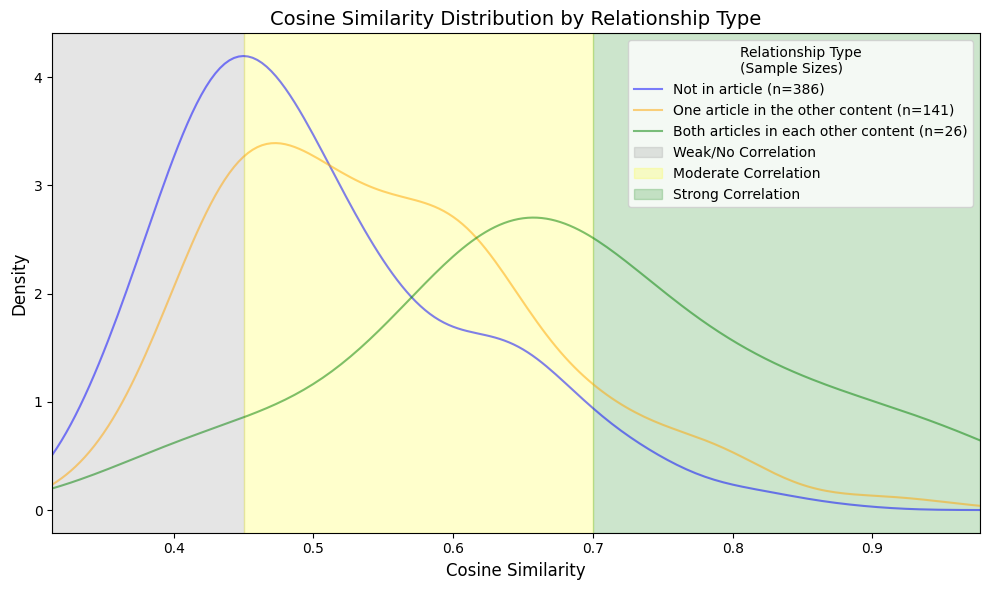

In [42]:
from scipy import stats

# Creating KDE plots for semantic distances based on relationship types
plt.figure(figsize=(10, 6))

# Get counts for each relationship type
none_count = len(analysis_df[analysis_df['relationship'] == 'none'])
both_count = len(analysis_df[analysis_df['relationship'] == 'both'])
directional_count = len(analysis_df[(analysis_df['relationship'] == 'forward_only') | 
                                  (analysis_df['relationship'] == 'reverse_only')])

# Define the range for plotting
distance_range = np.linspace(
    analysis_df['semantic_distance'].min(),
    analysis_df['semantic_distance'].max(),
    200
)

# Plot KDE for each relationship type
for relationship, color, label in [
    ('none', 'blue', 'Not in article'),
    (['forward_only', 'reverse_only'], 'orange', 'One article in the other content'),
    ('both', 'green', 'Both articles in each other content')
]:
    if isinstance(relationship, list):
        subset = analysis_df[analysis_df['relationship'].isin(relationship)]['semantic_distance']
    else:
        subset = analysis_df[analysis_df['relationship'] == relationship]['semantic_distance']
        
    if len(subset) > 0:  # Only create KDE if we have data points
        kde = stats.gaussian_kde(subset)
        plt.plot(distance_range, kde(distance_range), color=color, alpha=0.5,
                label=f'{label} (n={len(subset)})')

# Add correlation strength regions
plt.axvspan(analysis_df['semantic_distance'].min(), 0.45, alpha=0.2, color='gray', label='Weak/No Correlation')
plt.axvspan(0.45, 0.7, alpha=0.2, color='yellow', label='Moderate Correlation')
plt.axvspan(0.7, analysis_df['semantic_distance'].max(), alpha=0.2, color='green', label='Strong Correlation')
plt.xlim(analysis_df['semantic_distance'].min(),analysis_df['semantic_distance'].max())

# Adding title and labels
plt.title('Cosine Similarity Distribution by Relationship Type', fontsize=14)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Adding legend
plt.legend(title='Relationship Type\n(Sample Sizes)')

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()


In [43]:
print(f"There are {len(analysis_df[analysis_df['semantic_distance'] > 0.7])} links with a cosine similarity above 0.7")
print(f"There are {len(analysis_df[(analysis_df['semantic_distance'] > 0.45) & (analysis_df['semantic_distance'] < 0.7)])} links with a cosine similarity between 0.45 and 0.7")
print(f"There are {len(analysis_df[analysis_df['semantic_distance'] < 0.45])} links with a cosine similarity below 0.45")


There are 47 links with a cosine similarity above 0.7
There are 331 links with a cosine similarity between 0.45 and 0.7
There are 170 links with a cosine similarity below 0.45


After some research, we have found that for a cosine similarity above 0.7 :  The connections are extremely intuitive - many are simply different names for the same concept or closely related species. These links are so natural that their absence from the original network seems more like an oversight than a deliberate choice.
For a cosine similarity between 0.45 and 0.7, the articles are moderately correlated, meaning that the link is clear and should be added. #TODO : GIVE MORE EXAMPLES
For a cosine similarity below 0.45, the connections maintain some logical relationship - they connect articles within similar domains (literature, medical conditions, economic policy) while still requiring players to think creatively about the connections.

It's important to note that Wikispeedia uses only a small subset of Wikipedia articles, which means that many potential intermediate articles that could provide more natural connections are simply not available in the game. For instance, while "Romeo and Juliet" and "Julius and Ethel Rosenberg" might be better connected through articles about "Famous couples" or "Tragic love stories", such bridging articles are not part of the Wikispeedia dataset.

After comparison, our added links that we propose to add are more correlated and have stronger relationship than the ones in the game. 

---

### Analyse results



Distance statistics for Original graph:
Average finite distance: 2.84
Maximum finite distance: 9.0
Number of infinite distances: 2493637

Distance statistics for Closest Neighbors graph:
Average finite distance: 3.36
Maximum finite distance: 10.0
Number of infinite distances: 82845


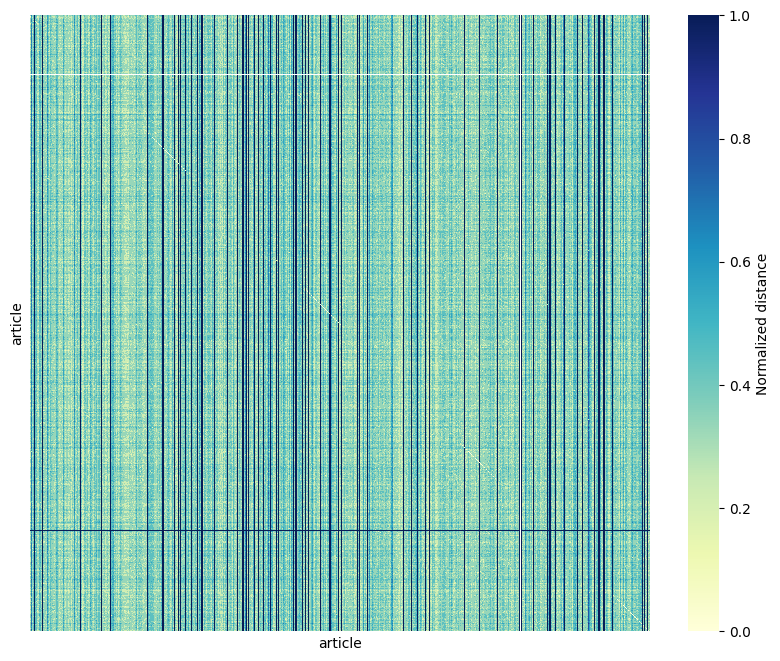

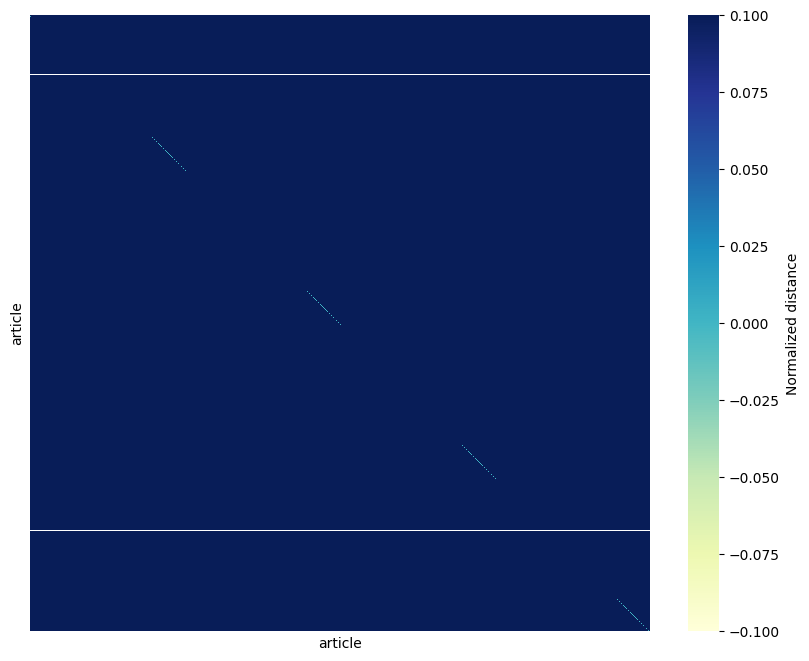

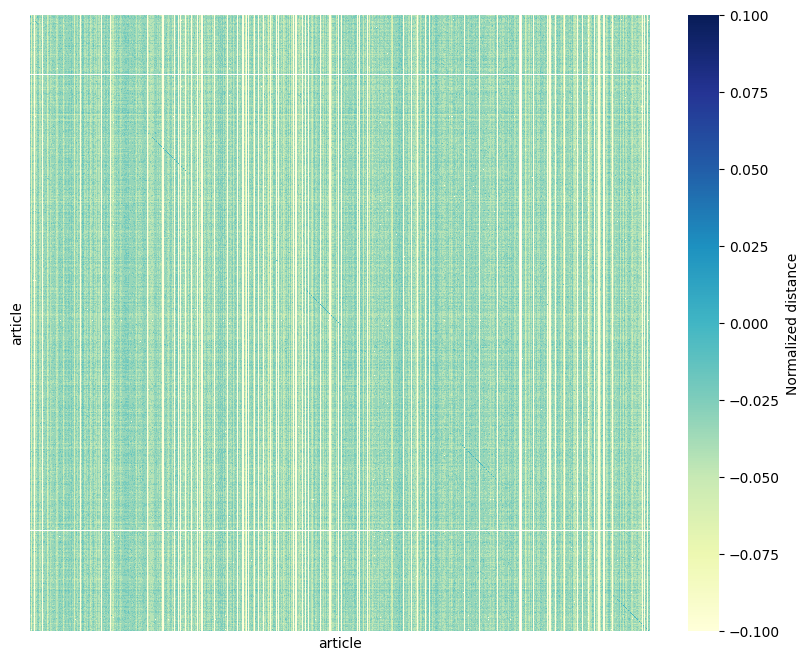

In [44]:
import seaborn as sns

# Compute distance matrices for each graph
distance_matrix_original = dict(nx.all_pairs_shortest_path_length(G))
distance_matrix_closest_neighbors = dict(nx.all_pairs_shortest_path_length(G_closest_neighbors))

# Convert to pandas DataFrames for easier analysis
def convert_distance_dict_to_df(distance_dict):
    df = pd.DataFrame.from_dict(distance_dict, orient='index')
    df = df.fillna(float('inf'))  # Replace NaN with infinity for disconnected nodes
    return df

df_dist_original = convert_distance_dict_to_df(distance_matrix_original)
df_dist_neighbors = convert_distance_dict_to_df(distance_matrix_closest_neighbors)

# Print some basic statistics about the distances
for name, df in [("Original", df_dist_original), 
                 ("Closest Neighbors", df_dist_neighbors)]:
    finite_distances = df[df != float('inf')]
    print(f"\nDistance statistics for {name} graph:")
    print(f"Average finite distance: {finite_distances.mean().mean():.2f}")
    print(f"Maximum finite distance: {finite_distances.max().max()}")
    print(f"Number of infinite distances: {(df == float('inf')).sum().sum()}")


# Reindex both distance matrices with sorted articles
df_dist_original = df_dist_original.reindex(index=articles['article'], columns=articles['article'])
df_dist_neighbors = df_dist_neighbors.reindex(index=articles['article'], columns=articles['article'])

# Normalize distance matrices by dividing by their maximum finite values
max_finite_original = df_dist_original[df_dist_original != float('inf')].max().max()
max_finite_neighbors = df_dist_neighbors[df_dist_neighbors != float('inf')].max().max()


#TODO: uncomment
# # Compare distances element by element
# same_count = 0
# diff_count = 0
# infinite_to_finite = 0
# total_compared = 0

# for col in tqdm(df_dist_original.columns):
#     for idx in df_dist_original.index:
#         # Compare all pairs, including when one is infinite and the other isn't
#         total_compared += 1
#         if (df_dist_original.loc[idx, col] == float('inf') and 
#             df_dist_neighbors.loc[idx, col] != float('inf')) or (df_dist_original.loc[idx, col] != float('inf') and 
#               df_dist_neighbors.loc[idx, col] == float('inf')):
#             infinite_to_finite += 1
#             diff_count += 1
#             #print(f"Distance is infinite for {idx} -> {col}")
            
#         elif df_dist_original.loc[idx, col] == df_dist_neighbors.loc[idx, col]:
#             same_count += 1
#         else:
#             #print(f"Distance is {df_dist_original.loc[idx, col]} vs {df_dist_neighbors.loc[idx, col]} for {idx} -> {col}")
#             diff_count += 1

# print(f"Number of positions with same distance: {same_count}")
# print(f"Number of positions with different distance: {diff_count}")
# print(f"Number of positions that were infinite and are now finite: {infinite_to_finite}")
# print(f"Total number of finite distance pairs compared: {total_compared}")
# print(f"Percentage of distances that are the same: {(same_count/total_compared)*100:.2f}%")



df_dist_original_normalized = df_dist_original / max_finite_original
df_dist_neighbors_normalized = df_dist_neighbors / max_finite_neighbors

# Replace infinity values with 1.0
df_dist_original_normalized = df_dist_original_normalized.replace(float('inf'), 1.0)
df_dist_original_normalized = df_dist_original_normalized.replace(float('inf'), 1.0)


# Recalculate differences with sorted matrices
differences = df_dist_neighbors_normalized - df_dist_original_normalized
plt.figure(figsize=(10, 8))
sns.heatmap(df_dist_original_normalized, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Normalized distance'}, xticklabels=False, yticklabels=False)
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(df_dist_neighbors_normalized, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Normalized distance'}, xticklabels=False, yticklabels=False)
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(differences, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Normalized distance'}, xticklabels=False, yticklabels=False)
plt.show()



## **Additionnal visualizations**

In [45]:
# Create the initial figure
# Create widgets for path selection

def update_path(path_type, path_number):
    if path_type == 'Unfinished Paths':
        paths_df = paths_unfinished
    else:
        paths_df = paths_finished
        
    example_path = paths_df['traversed'].iloc[path_number]
    target = paths_df['target'].iloc[path_number]
    print(f"Path: {example_path}")
    print(f"Target: {target}")
    visualize_path(example_path, reduced_embeddings3D, all_words_df, target)

path_type = widgets.RadioButtons(
    options=['Unfinished Paths', 'Finished Paths'],
    description='Path Type:',
    disabled=False
)

path_number = widgets.IntText(
    value=1021,
    description='Path ID:',
    disabled=False
)
initial_path = paths_unfinished['traversed'].iloc[1021]
initial_target = paths_unfinished['target'].iloc[1021]
fig = visualize_path(initial_path, reduced_embeddings3D, all_words_df, initial_target)
display(fig)

widgets.interactive(update_path, path_type=path_type, path_number=path_number)

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'lightgray', 'opacity': 0.3, 'size': 3},
              'mode': 'markers',
              'name': 'All articles',
              'text': array(['Áedán mac Gabráin', "One Flew Over the Cuckoo's Nest (novel)",
                             'Open cluster', ..., 'Fluorine', 'Flute', 'Zulu'], dtype=object),
              'type': 'scatter3d',
              'uid': 'e1ace19c-2566-4bbb-ab60-5a8eed8884ef',
              'x': array([-25.473059, -11.919358,  29.226793, ...,  25.047794, -14.294389,
                           11.342342], dtype=float32),
              'y': array([ 19.033033 ,  -9.4885845,   8.50076  , ..., -12.606771 , -17.919418 ,
                           15.911677 ], dtype=float32),
              'z': array([-10.286324 , -19.12454  ,  -2.665062 , ...,   4.4006977, -15.835214 ,
                            1.4663593], dtype=float32)},
             {'hoverinfo': 'text',
              'line': {'color': 'r

interactive(children=(RadioButtons(description='Path Type:', options=('Unfinished Paths', 'Finished Paths'), v…

## Same thing in 2D, can be clearer in some cases

In [46]:
path_id = 906
example_path = paths_unfinished['traversed'].iloc[path_id]
target = paths_unfinished['target'].iloc[path_id]
print(target)
print(example_path)
fig = visualize_path_2D(example_path, reduced_embeddings, all_words_df, target)
fig.show()

Chemical synapse
['Cattle', 'Scientific classification', 'Evolution', 'DNA', 'Biology', 'Human', 'Mind', 'Cell (biology)']


We have officially saved Christmas, allowing Santa Claus to join the party ! 